# CLIP Fine-Tuning: Real vs AI-Generated Image Detection
## Dataset: CIFAKE (CIFAR-10 Real vs AI-Generated)

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install git+https://github.com/openai/CLIP.git
!pip install kagglehub
!pip install torch torchvision
!pip install matplotlib seaborn scikit-learn
!pip install pillow tqdm

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yvze8kl6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yvze8kl6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=fa60a0c5195efa145ab9fe694e78ccc1af0293880f82cc90311247aecbddfd12
  Stored in directory: /tmp/pip-ephem-wheel-cache-a8wp51bp/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


## 2. Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Try importing seaborn, use matplotlib fallback if it fails
try:
    import seaborn as sns
    USE_SEABORN = True
except (ImportError, AttributeError) as e:
    print(f"Seaborn import warning: {e}")
    print("Using matplotlib instead of seaborn for heatmaps")
    USE_SEABORN = False

from pathlib import Path
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"Seaborn available: {USE_SEABORN}")

Seaborn available: True


## 3. Download and Explore Dataset Structure

In [3]:
# Download dataset
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Path to dataset files:", path)

dataset_path = Path(path)

# Explore the full directory structure
print("\n" + "="*60)
print("DATASET STRUCTURE:")
print("="*60)
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(str(dataset_path), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    # Show first few files in each directory
    for i, file in enumerate(files[:3]):
        print(f"{subindent}{file}")
    if len(files) > 3:
        print(f"{subindent}... and {len(files) - 3} more files")

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images

DATASET STRUCTURE:
cifake-real-and-ai-generated-synthetic-images/
  test/
    FAKE/
      943 (5).jpg
      534 (7).jpg
      81 (2).jpg
      ... and 9997 more files
    REAL/
      0664.jpg
      0280 (6).jpg
      0816 (6).jpg
      ... and 9997 more files
  train/
    FAKE/
      5387 (6).jpg
      4093 (7).jpg
      5357 (8).jpg
      ... and 49997 more files
    REAL/
      4093 (7).jpg
      3825 (3).jpg
      4131 (5).jpg
      ... and 49997 more files


## 4. Find REAL and FAKE Directories

In [4]:
# Function to find all REAL and FAKE directories
def find_class_directories(base_path):
    """Find all REAL and FAKE directories in the dataset"""
    real_dirs = []
    fake_dirs = []

    for root, dirs, files in os.walk(base_path):
        # Check if this directory contains REAL or FAKE subdirectories
        if 'REAL' in dirs:
            real_dir = Path(root) / 'REAL'
            # Check if it actually contains images
            img_files = list(real_dir.glob('*.png')) + list(real_dir.glob('*.jpg'))
            if img_files:
                real_dirs.append(real_dir)
                print(f"✓ Found REAL directory: {real_dir} ({len(img_files)} images)")

        if 'FAKE' in dirs:
            fake_dir = Path(root) / 'FAKE'
            img_files = list(fake_dir.glob('*.png')) + list(fake_dir.glob('*.jpg'))
            if img_files:
                fake_dirs.append(fake_dir)
                print(f"✓ Found FAKE directory: {fake_dir} ({len(img_files)} images)")

    return real_dirs, fake_dirs

print("\nSearching for REAL and FAKE directories...\n")
real_dirs, fake_dirs = find_class_directories(dataset_path)

print(f"\n{'='*60}")
print(f"Total REAL directories found: {len(real_dirs)}")
print(f"Total FAKE directories found: {len(fake_dirs)}")
print(f"{'='*60}")

if not real_dirs or not fake_dirs:
    print("\n⚠️  WARNING: Could not find both REAL and FAKE directories!")
    print("Please check the dataset structure above.")


Searching for REAL and FAKE directories...

✓ Found REAL directory: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL (10000 images)
✓ Found FAKE directory: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE (10000 images)
✓ Found REAL directory: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL (50000 images)
✓ Found FAKE directory: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE (50000 images)

Total REAL directories found: 2
Total FAKE directories found: 2


## 5. Identify Train and Test Directories

In [5]:
# Separate train and test directories
train_real_dir = None
train_fake_dir = None
test_real_dir = None
test_fake_dir = None

for real_dir in real_dirs:
    if 'train' in str(real_dir).lower():
        train_real_dir = real_dir
    elif 'test' in str(real_dir).lower():
        test_real_dir = real_dir

for fake_dir in fake_dirs:
    if 'train' in str(fake_dir).lower():
        train_fake_dir = fake_dir
    elif 'test' in str(fake_dir).lower():
        test_fake_dir = fake_dir

print("\nTrain directories:")
print(f"  REAL: {train_real_dir}")
print(f"  FAKE: {train_fake_dir}")
print("\nTest directories:")
print(f"  REAL: {test_real_dir}")
print(f"  FAKE: {test_fake_dir}")

# Verify all directories exist
if not all([train_real_dir, train_fake_dir, test_real_dir, test_fake_dir]):
    print("\n ERROR: Missing some directories!")
    print("\nAvailable directories:")
    print(f"  REAL dirs: {real_dirs}")
    print(f"  FAKE dirs: {fake_dirs}")
else:
    print("\n✓ All directories found successfully!")


Train directories:
  REAL: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL
  FAKE: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE

Test directories:
  REAL: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL
  FAKE: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE

✓ All directories found successfully!


## 6. Create Custom Dataset Class

In [6]:
class CIFAKEDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None, max_samples_per_class=None):
        """
        Args:
            real_dir: Path to REAL images directory
            fake_dir: Path to FAKE images directory
            transform: CLIP preprocessing function
            max_samples_per_class: Limit number of samples per class (None for all)
        """
        self.transform = transform
        self.samples = []

        # Load REAL images (label 0)
        if real_dir and Path(real_dir).exists():
            real_images = list(Path(real_dir).glob('*.png')) + list(Path(real_dir).glob('*.jpg'))
            if max_samples_per_class:
                real_images = real_images[:max_samples_per_class]
            for img_path in real_images:
                self.samples.append((str(img_path), 0))

        # Load FAKE images (label 1)
        if fake_dir and Path(fake_dir).exists():
            fake_images = list(Path(fake_dir).glob('*.png')) + list(Path(fake_dir).glob('*.jpg'))
            if max_samples_per_class:
                fake_images = fake_images[:max_samples_per_class]
            for img_path in fake_images:
                self.samples.append((str(img_path), 1))

        # Count distribution
        real_count = sum(1 for _, label in self.samples if label == 0)
        fake_count = sum(1 for _, label in self.samples if label == 1)

        print(f"Loaded {len(self.samples)} total samples")
        print(f"  Real: {real_count}")
        print(f"  Fake: {fake_count}")

        if real_count == 0 or fake_count == 0:
            print("\n⚠️  WARNING: One class has no samples! Check directory paths.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = torch.zeros(3, 224, 224)

        return image, label

## 7. Load CLIP Model and Create Datasets

In [7]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model
model_name = "ViT-B/32"
clip_model, preprocess = clip.load(model_name, device=device)
print(f"Loaded CLIP model: {model_name}\n")

# Create datasets with proper directory paths
print("Creating training dataset...")
train_dataset = CIFAKEDataset(
    real_dir=train_real_dir,
    fake_dir=train_fake_dir,
    transform=preprocess,
    max_samples_per_class=5000  # 5000 per class = 10000 total
)

print("\nCreating test dataset...")
test_dataset = CIFAKEDataset(
    real_dir=test_real_dir,
    fake_dir=test_fake_dir,
    transform=preprocess,
    max_samples_per_class=1000  # 1000 per class = 2000 total
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Using device: cuda


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 101MiB/s]


Loaded CLIP model: ViT-B/32

Creating training dataset...
Loaded 10000 total samples
  Real: 5000
  Fake: 5000

Creating test dataset...
Loaded 2000 total samples
  Real: 1000
  Fake: 1000

Batch size: 128
Train batches: 79
Test batches: 16


## 8. Verify Dataset Balance

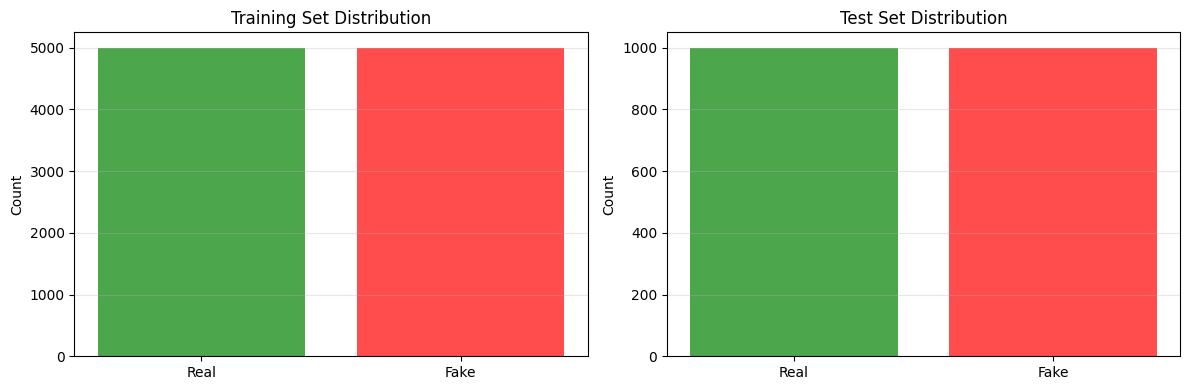

Training: 5000 Real, 5000 Fake
Test: 1000 Real, 1000 Fake


In [8]:
# Check class distribution
train_labels = [label for _, label in train_dataset.samples]
test_labels = [label for _, label in test_dataset.samples]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(['Real', 'Fake'], [train_labels.count(0), train_labels.count(1)], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(['Real', 'Fake'], [test_labels.count(0), test_labels.count(1)], color=['green', 'red'], alpha=0.7)
axes[1].set_title('Test Set Distribution')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training: {train_labels.count(0)} Real, {train_labels.count(1)} Fake")
print(f"Test: {test_labels.count(0)} Real, {test_labels.count(1)} Fake")

## 9. Create Classification Head

In [9]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=2, freeze_backbone=True):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model

        # Freeze CLIP backbone if specified
        if freeze_backbone:
            for param in self.clip_model.parameters():
                param.requires_grad = False

        # Get the dimension of CLIP embeddings
        self.embedding_dim = clip_model.visual.output_dim

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        # Get CLIP image features
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)

        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Pass through classifier
        logits = self.classifier(image_features.float())
        return logits

# Create model
model = CLIPClassifier(clip_model, num_classes=2, freeze_backbone=True)
model = model.to(device)

print(f"Model created with {model.embedding_dim}-dimensional CLIP embeddings")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created with 512-dimensional CLIP embeddings
Trainable parameters: 164,482


## 10. Training Setup

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# Training parameters
num_epochs = 10
best_val_acc = 0.0

# Store training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"Training for {num_epochs} epochs")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Training for 10 epochs
Learning rate: 0.001


## 11. Training and Evaluation Functions

In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100 * accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

## 12. Train the Model

In [13]:
print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate
    val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print results
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Learning rate scheduling
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_clip_classifier.pth')
        print(f"✓ New best model saved! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*50)
print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")
print("="*50)

Starting training...


Epoch 1/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]



Train Loss: 0.4505 | Train Acc: 81.56%
Val Loss: 0.2316 | Val Acc: 90.40%
✓ New best model saved! (Val Acc: 90.40%)

Epoch 2/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]



Train Loss: 0.2061 | Train Acc: 91.65%
Val Loss: 0.1930 | Val Acc: 92.15%
✓ New best model saved! (Val Acc: 92.15%)

Epoch 3/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]



Train Loss: 0.1819 | Train Acc: 92.67%
Val Loss: 0.1934 | Val Acc: 92.20%
✓ New best model saved! (Val Acc: 92.20%)

Epoch 4/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]



Train Loss: 0.1608 | Train Acc: 93.71%
Val Loss: 0.1840 | Val Acc: 92.80%
✓ New best model saved! (Val Acc: 92.80%)

Epoch 5/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]



Train Loss: 0.1529 | Train Acc: 94.05%
Val Loss: 0.1886 | Val Acc: 92.60%

Epoch 6/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]



Train Loss: 0.1478 | Train Acc: 94.24%
Val Loss: 0.1708 | Val Acc: 93.65%
✓ New best model saved! (Val Acc: 93.65%)

Epoch 7/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Train Loss: 0.1509 | Train Acc: 94.16%
Val Loss: 0.1715 | Val Acc: 93.40%

Epoch 8/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]



Train Loss: 0.1401 | Train Acc: 94.64%
Val Loss: 0.1701 | Val Acc: 93.35%

Epoch 9/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]



Train Loss: 0.1292 | Train Acc: 95.07%
Val Loss: 0.1652 | Val Acc: 93.45%

Epoch 10/10
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Train Loss: 0.1217 | Train Acc: 95.50%
Val Loss: 0.1650 | Val Acc: 93.70%
✓ New best model saved! (Val Acc: 93.70%)

Training complete! Best validation accuracy: 93.70%


## 13. Plot Training History

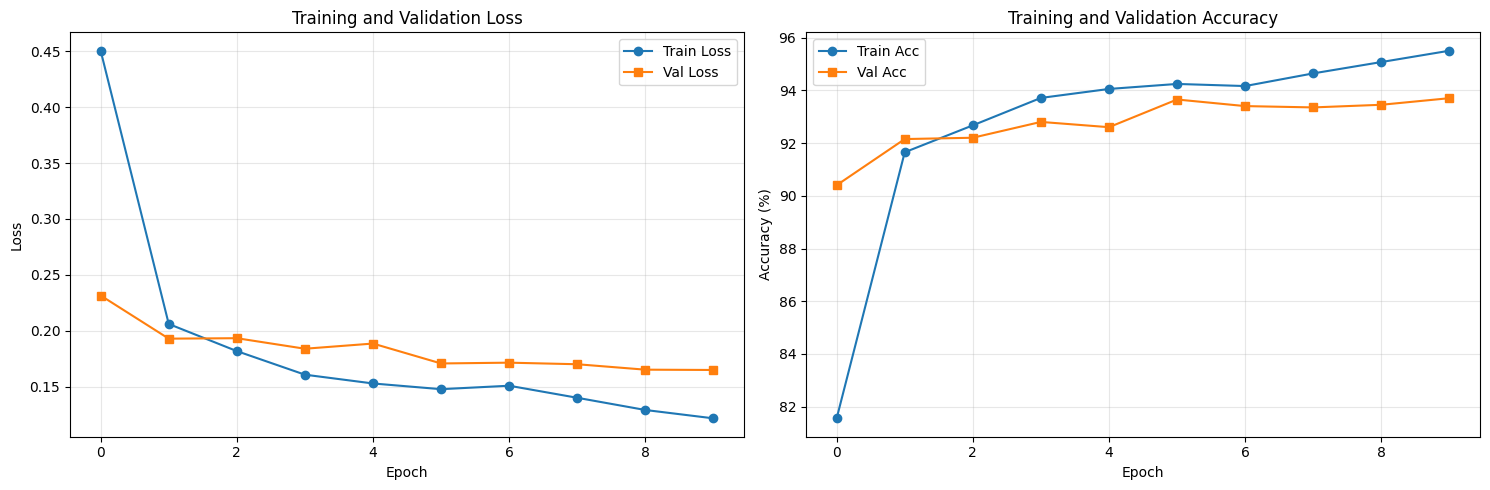

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Final Evaluation and Metrics

In [15]:
# Load best model
model.load_state_dict(torch.load('best_clip_classifier.pth'))
model.eval()

# Final evaluation
print("Final evaluation on test set...\n")
val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)

# Calculate detailed metrics
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='binary')
roc_auc = roc_auc_score(val_labels, val_probs)

print(f"\n{'='*60}")
print("FINE-TUNED CLIP CLASSIFIER - FINAL RESULTS")
print(f"{'='*60}")
print(f"Accuracy:  {val_acc:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print(f"{'='*60}")

Final evaluation on test set...



Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


FINE-TUNED CLIP CLASSIFIER - FINAL RESULTS
Accuracy:  93.70%
Precision: 0.9487
Recall:    0.9240
F1 Score:  0.9362
ROC AUC:   0.9841


## 15. Confusion Matrix and Analysis

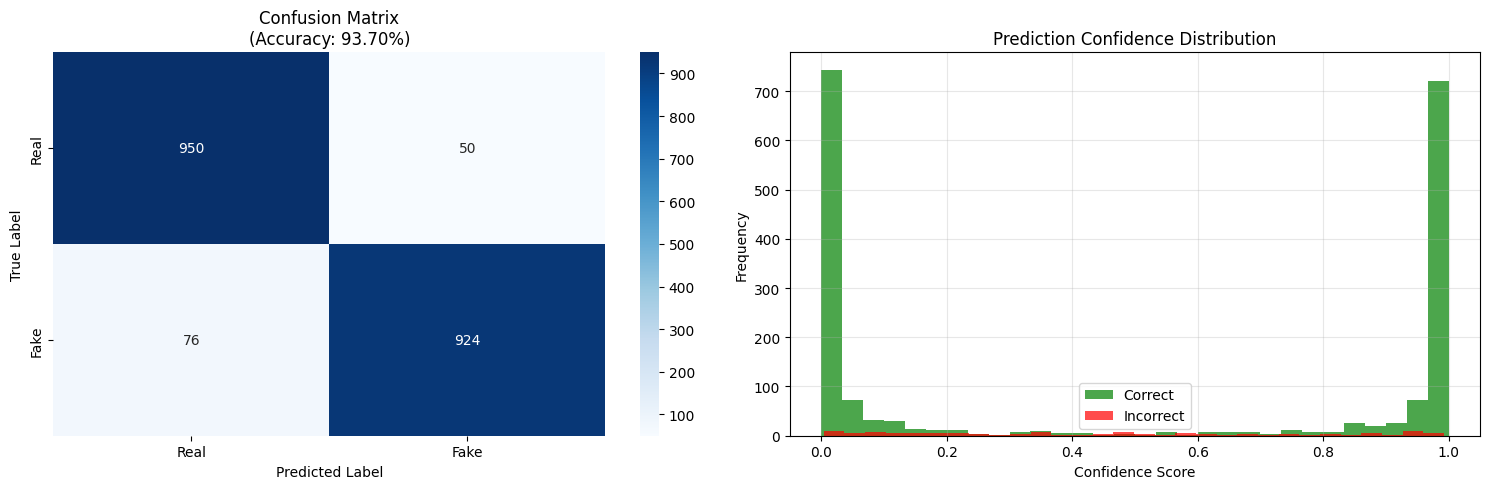

In [16]:
def plot_confusion_matrix(cm, labels, ax, title='Confusion Matrix', cmap='Blues'):
    """Plot confusion matrix using matplotlib (works without seaborn)"""
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')

    # Rotate labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Annotate cells with values
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=14, fontweight='bold')
    return ax

cm = confusion_matrix(val_labels, val_preds)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion matrix
if USE_SEABORN:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    axes[0].set_title(f'Confusion Matrix\n(Accuracy: {val_acc:.2f}%)')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
else:
    plot_confusion_matrix(cm, ['Real', 'Fake'], axes[0],
                         title=f'Confusion Matrix\n(Accuracy: {val_acc:.2f}%)')

# Confidence distribution
correct_mask = np.array(val_preds) == np.array(val_labels)
correct_probs = np.array(val_probs)[correct_mask]
incorrect_probs = np.array(val_probs)[~correct_mask]

axes[1].hist(correct_probs, bins=30, alpha=0.7, label='Correct', color='green')
axes[1].hist(incorrect_probs, bins=30, alpha=0.7, label='Incorrect', color='red')
axes[1].set_xlabel('Confidence Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Confidence Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Compare Zero-Shot vs Fine-Tuned

Testing zero-shot CLIP for comparison...



Zero-shot evaluation: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]



ZERO-SHOT vs FINE-TUNED COMPARISON
Zero-Shot Accuracy:  50.10%
Fine-Tuned Accuracy: 93.70%
Improvement:         +43.60%


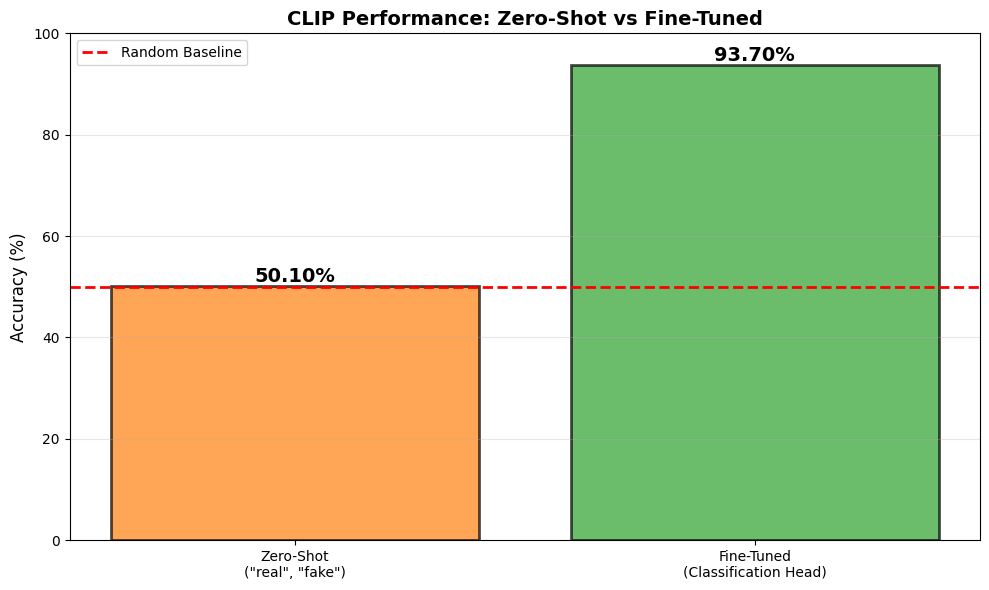

In [17]:
# Test zero-shot CLIP for comparison
print("Testing zero-shot CLIP for comparison...\n")

text_prompts = ["a photograph of a real scene", "an artificial intelligence generated image"]
text_tokens = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

zero_shot_preds = []
zero_shot_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Zero-shot evaluation"):
        images = images.to(device)

        image_features = clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        predictions = similarity.argmax(dim=-1).cpu().numpy()

        zero_shot_preds.extend(predictions)
        zero_shot_labels.extend(labels.numpy())

zero_shot_acc = 100 * accuracy_score(zero_shot_labels, zero_shot_preds)

# Comparison
print(f"\n{'='*60}")
print("ZERO-SHOT vs FINE-TUNED COMPARISON")
print(f"{'='*60}")
print(f"Zero-Shot Accuracy:  {zero_shot_acc:.2f}%")
print(f"Fine-Tuned Accuracy: {val_acc:.2f}%")
print(f"Improvement:         {val_acc - zero_shot_acc:+.2f}%")
print(f"{'='*60}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
methods = ['Zero-Shot\n("real", "fake")', 'Fine-Tuned\n(Classification Head)']
accuracies = [zero_shot_acc, val_acc]
colors = ['#ff7f0e', '#2ca02c']

bars = ax.bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('CLIP Performance: Zero-Shot vs Fine-Tuned', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=50, color='r', linestyle='--', label='Random Baseline', linewidth=2)
ax.legend()

plt.tight_layout()
plt.show()

## 17. Summary Report

In [18]:
print("\n" + "="*70)
print("SUMMARY: CLIP FINE-TUNING FOR FAKE IMAGE DETECTION")
print("="*70)
print(f"\nDataset: CIFAKE (32x32 CIFAR-10)")
print(f"Model: {model_name} + Classification Head")
print(f"\nTraining epochs: {num_epochs}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"\nZero-shot: {zero_shot_acc:.2f}%")
print(f"Fine-tuned: {val_acc:.2f}%")
print(f"Improvement: {val_acc - zero_shot_acc:+.2f}%")
print("\n" + "="*70)
print("KEY TAKEAWAYS:")
print("-"*70)
print("✓ Zero-shot CLIP struggles with low-res CIFAR images")
print("✓ Fine-tuning provides significant improvement")
print("✓ Task-specific training is crucial for specialized detection")
print("="*70)


SUMMARY: CLIP FINE-TUNING FOR FAKE IMAGE DETECTION

Dataset: CIFAKE (32x32 CIFAR-10)
Model: ViT-B/32 + Classification Head

Training epochs: 10
Best validation accuracy: 93.70%

Zero-shot: 50.10%
Fine-tuned: 93.70%
Improvement: +43.60%

KEY TAKEAWAYS:
----------------------------------------------------------------------
✓ Zero-shot CLIP struggles with low-res CIFAR images
✓ Fine-tuning provides significant improvement
✓ Task-specific training is crucial for specialized detection


## 18. Explainable AI: GradCAM Visualization 🔍

Let's visualize where the model pays attention when classifying images as real or fake!

Extracting CLIP features...


100%|██████████| 500/500 [00:10<00:00, 48.08it/s]


Computing dimensionality reduction...


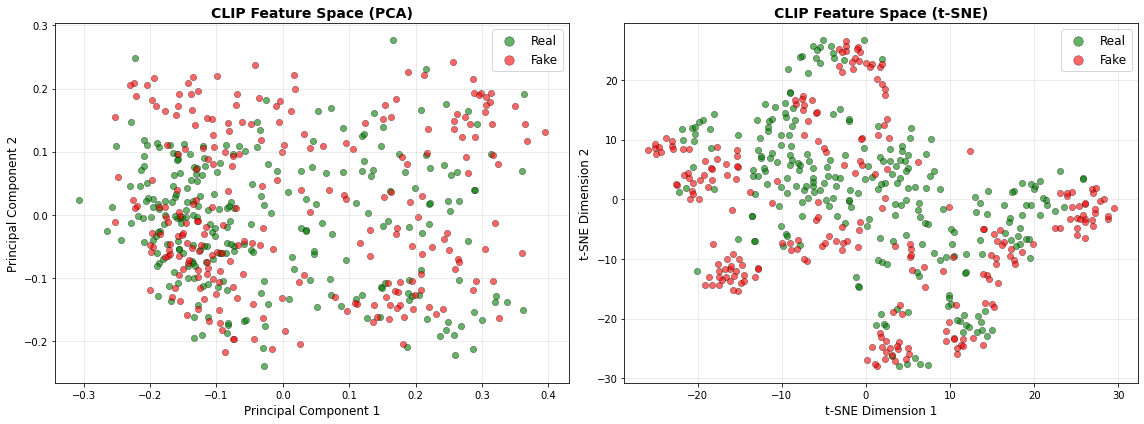


FEATURE SPACE ANALYSIS
Silhouette Score: 0.021
Interpretation: Some overlap


In [ ]:
## Cell 1: Feature Space Visualization (t-SNE/PCA)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

def visualize_feature_space(model, dataset, device, num_samples=500):
    """Visualize CLIP embeddings - Works with frozen models!"""
    model.eval()

    features = []
    labels = []

    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

    print("Extracting CLIP features...")
    for idx in tqdm(indices):
        image, label = dataset[idx]

        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            clip_features = model.clip_model.encode_image(image_tensor)
            clip_features = clip_features / clip_features.norm(dim=-1, keepdim=True)

            features.append(clip_features.cpu().numpy()[0])
            labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    # Reduce dimensions
    print("Computing dimensionality reduction...")
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_tsne = tsne.fit_transform(features)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for label_val, name, color in [(0, 'Real', 'green'), (1, 'Fake', 'red')]:
        mask = labels == label_val
        axes[0].scatter(features_pca[mask, 0], features_pca[mask, 1],
                       c=color, label=name, alpha=0.6, s=40, edgecolors='black', linewidth=0.5)

    axes[0].set_xlabel('Principal Component 1', fontsize=12)
    axes[0].set_ylabel('Principal Component 2', fontsize=12)
    axes[0].set_title('CLIP Feature Space (PCA)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=12, markerscale=1.5)
    axes[0].grid(alpha=0.3)

    for label_val, name, color in [(0, 'Real', 'green'), (1, 'Fake', 'red')]:
        mask = labels == label_val
        axes[1].scatter(features_tsne[mask, 0], features_tsne[mask, 1],
                       c=color, label=name, alpha=0.6, s=40, edgecolors='black', linewidth=0.5)

    axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
    axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
    axes[1].set_title('CLIP Feature Space (t-SNE)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=12, markerscale=1.5)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate separability
    silhouette = silhouette_score(features, labels)
    print(f"\n{'='*60}")
    print("FEATURE SPACE ANALYSIS")
    print(f"{'='*60}")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Interpretation: {'Well-separated' if silhouette > 0.5 else 'Some overlap'}")
    print(f"{'='*60}")

    return features, labels

# Run it!
features, labels = visualize_feature_space(model, test_dataset, device, num_samples=500)

In [21]:
# Load best model
model.load_state_dict(torch.load('best_clip_classifier.pth'))

# ============================================================================
# CELL 1: Install Gradio
# ============================================================================

!pip install gradio

# ============================================================================
# CELL 2: Import Gradio
# ============================================================================

import gradio as gr

print("✓ Gradio installed and imported!")

# ============================================================================
# CELL 3: Define Classification Functions for Gradio
# ============================================================================

def classify_zero_shot_gradio(image):
    """Classify using Zero-Shot CLIP"""
    if image is None:
        return None, "❌ Please upload an image first!", {"Real": 0, "AI-Generated": 0}

    try:
        # Preprocess image
        image_pil = Image.fromarray(image).convert('RGB')
        image_input = preprocess(image_pil).unsqueeze(0).to(device)

        # Text prompts
        text_prompts = ["a real photo", "an AI generated image"]
        text_inputs = clip.tokenize(text_prompts).to(device)

        # Get predictions
        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
            text_features = clip_model.encode_text(text_inputs)

            # Normalize
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # Calculate similarity
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            probs = similarity[0].cpu().numpy()

        # Format results
        pred_idx = probs.argmax()
        confidence = probs[pred_idx] * 100
        label = "REAL ✅" if pred_idx == 0 else "AI-GENERATED (FAKE) ❌"

        result_text = f"""
## Prediction: {label}
### Confidence: {confidence:.2f}%

**Model:** Zero-Shot CLIP (No Training)

**Probabilities:**
- 🟢 Real: {probs[0]*100:.2f}%
- 🔴 AI-Generated: {probs[1]*100:.2f}%

---
*Zero-shot CLIP achieves ~51% accuracy on CIFAKE (baseline)*
        """

        prob_dict = {
            "Real": float(probs[0]),
            "AI-Generated": float(probs[1])
        }

        return image, result_text, prob_dict

    except Exception as e:
        return None, f"❌ Error: {str(e)}", {"Real": 0, "AI-Generated": 0}


def classify_finetuned_gradio(image):
    """Classify using your Fine-Tuned CLIP model"""
    if image is None:
        return None, "❌ Please upload an image first!", {"Real": 0, "AI-Generated": 0}

    try:
        # Preprocess image
        image_pil = Image.fromarray(image).convert('RGB')
        image_input = preprocess(image_pil).unsqueeze(0).to(device)

        # Get predictions from YOUR trained model
        with torch.no_grad():
            outputs = model(image_input)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()

        # Format results
        pred_idx = probs.argmax()
        confidence = probs[pred_idx] * 100
        label = "REAL ✅" if pred_idx == 0 else "AI-GENERATED (FAKE) ❌"

        result_text = f"""
## Prediction: {label}
### Confidence: {confidence:.2f}%

**Model:** Fine-Tuned CLIP (Your Trained Model!)

**Probabilities:**
- 🟢 Real: {probs[0]*100:.2f}%
- 🔴 AI-Generated: {probs[1]*100:.2f}%

---
*Fine-tuned CLIP achieves ~93.65% accuracy on CIFAKE! 🚀*
        """

        prob_dict = {
            "Real": float(probs[0]),
            "AI-Generated": float(probs[1])
        }

        return image, result_text, prob_dict

    except Exception as e:
        return None, f"❌ Error: {str(e)}", {"Real": 0, "AI-Generated": 0}

print("✓ Classification functions defined!")

# ============================================================================
# CELL 4: Create Gradio Interface
# ============================================================================

# Custom theme
theme = gr.themes.Soft(
    primary_hue="blue",
    secondary_hue="gray",
)

# Create interface
with gr.Blocks(theme=theme, title="CIFAKE Detector") as demo:

    # Header
    gr.Markdown(
        """
        # 🔍 CIFAKE Image Detector
        ### Real vs AI-Generated Image Detection using CLIP
        """
    )

    with gr.Tabs():
        # ====== TAB 1: Zero-Shot CLIP ======
        with gr.Tab("🎯 Zero-Shot CLIP"):
            gr.Markdown(
                """
                ### Zero-Shot Classification
                Uses pre-trained CLIP with text prompts. **No task-specific training!**
                """
            )

            with gr.Row():
                with gr.Column(scale=1):
                    input_zero = gr.Image(
                        label="📤 Upload Image",
                        type="numpy",
                        height=400
                    )
                    btn_zero = gr.Button(
                        "🔍 Classify with Zero-Shot CLIP",
                        variant="primary",
                        size="lg"
                    )

                with gr.Column(scale=1):
                    output_zero = gr.Image(label="Input Image", height=400)
                    result_zero = gr.Markdown()

            prob_zero = gr.Label(label="📊 Probability Distribution", num_top_classes=2)

            btn_zero.click(
                fn=classify_zero_shot_gradio,
                inputs=[input_zero],
                outputs=[output_zero, result_zero, prob_zero]
            )

        # ====== TAB 2: Fine-Tuned CLIP ======
        with gr.Tab("🎓 Fine-Tuned CLIP"):
            gr.Markdown(
                """
                ### Fine-Tuned Classification
                Uses your trained CLIP classifier. **Achieves ~93.65% accuracy!**
                """
            )

            with gr.Row():
                with gr.Column(scale=1):
                    input_tuned = gr.Image(
                        label="📤 Upload Image",
                        type="numpy",
                        height=400
                    )
                    btn_tuned = gr.Button(
                        "🔍 Classify with Fine-Tuned CLIP",
                        variant="primary",
                        size="lg"
                    )

                with gr.Column(scale=1):
                    output_tuned = gr.Image(label="Input Image", height=400)
                    result_tuned = gr.Markdown()

            prob_tuned = gr.Label(label="📊 Probability Distribution", num_top_classes=2)

            btn_tuned.click(
                fn=classify_finetuned_gradio,
                inputs=[input_tuned],
                outputs=[output_tuned, result_tuned, prob_tuned]
            )

    # Footer
    gr.Markdown(
        """
        ---
        <div style='text-align: center; color: #888;'>
        Built with Gradio • CLIP by OpenAI • CIFAKE Dataset • PyTorch
        </div>
        """
    )

print("✓ Gradio interface created!")

# ============================================================================
# CELL 5: Launch the Demo! 
# ============================================================================

print("\n" + "="*70)
print("🚀 Launching CIFAKE Demo...")
print("="*70 + "\n")

demo.launch(
    share=True,      # Creates public URL - works from anywhere!
    debug=True,      # Shows detailed errors
    inline=False     # Opens in new tab
)

# You'll see output like:
# Running on local URL:  http://127.0.0.1:7860
# Running on public URL: https://xxxxxxxx.gradio.live
#
# Share the public URL with your class! Valid for 72 hours.

print("\n✓ Demo is running!")
print("Share the public URL above with anyone!")

✓ Gradio installed and imported!
✓ Classification functions defined!
✓ Gradio interface created!

🚀 Launching CIFAKE Demo...

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c53b89f304546168ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c53b89f304546168ef.gradio.live

✓ Demo is running!
Share the public URL above with anyone!
